# Convolution networks

In [1]:
#@title Imports (RUN ME!) { display-mode: "form" }

!pip -q install pydot_ng
!pip -q install graphviz
!apt install graphviz > /dev/null

from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline



The screen cannot be set to the number of lines and columns specified.
The screen cannot be set to the number of lines and columns specified.
The screen cannot be set to the number of lines and columns specified.


A convolutional layer maps an input *volume* (meaning, a 3-D input tensor, e.g. [width, height, channels]) to an output volume through a set of learnable filters, which make up the parameters of the layer. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. (Eg: A filter in the first layer of a ConvNet might have size [5, 5, 3]). During the forward pass, we convolve ("slide") each filter across the width and height of the input volume and compute element-wise dot products between the entries of the filter and the input at any position. As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Each convolutional layer will have such a set of filters, and each of them will produce a separate 2-dimensional activation map. We then stack these activation maps along the depth-dimension to produce the output volume.

By using these filters which map to a small sub-volume of the input, we can to a large extent,control the parameter explosion that we would get with a (fully-connected) feed-forward network. This **parameter sharing** actually also tends to improve the performance of the model on inputs like natural images because it provides the model with some limited **translation invariance**. Translation invariance means that if the image (or a feature in the image) is translated (moved), the model will not be significantly affected. Think about why this is the case!

The following animation illustrates these ideas, make sure you understand them!

![Convolution Animation](https://i.stack.imgur.com/FjvuN.gif)

The hyper-parameters of a convolutional layer are as follows:
* **Filters** defines the number of filters in the layer
* **Kernel Size** defines the width and height of the filters (also called "kernels") in the layer. Note that kernels always have the same depth as the inputs to the layer.
* **Stride** defines the number of pixels by which we move the filter when "sliding" it along the input volume. Typically this value would be 1, but values of 2 and 3 are also sometimes used.
* **Padding** refers to the addition of 0-value pixels to the edges of the input volume along the width and height dimensions. In Tensorflow you can set this to "VALID", which essentially does no padding or "SAME" which pads the input such that the output width and height are the same as the input.

Lets look at a very simple, dummy example to see how the values of the hyper-parameters affect the output size of a convolutional layer.

Input shape: (10, 10, 3)


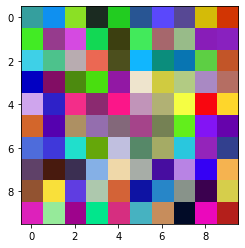

In [4]:
# Create a random colour "image" of shape 10x10 with a depth of 3 (for red, green and blue)
dummy_input = np.random.uniform(size=[10, 10, 3])
fig, ax = plt.subplots(1, 1)
plt.imshow(dummy_input)
ax.grid(False)
print('Input shape: {}'.format(dummy_input.shape))

In [3]:
num = np.random.uniform(low=0.0, high=2.0, size=[12,12])
num

array([[1.53208348, 1.77962496, 1.83900705, 1.86435621, 0.06734104,
        0.30476438, 1.7724569 , 0.26480978, 1.88783642, 0.44495428,
        0.36144938, 0.37331674],
       [0.00393752, 1.427128  , 1.11150669, 1.30680882, 0.38877047,
        0.76188566, 1.7077898 , 1.30462322, 0.36140462, 0.86036288,
        0.38832669, 0.28445515],
       [0.82288165, 1.1812321 , 1.50483063, 0.25806049, 1.6055888 ,
        1.86988763, 1.8315864 , 0.81073168, 0.26822202, 1.99868989,
        0.82159691, 1.64424382],
       [1.18175068, 0.59007516, 1.34030167, 1.24274299, 1.40396331,
        1.41265277, 1.61620688, 0.7481343 , 0.04919438, 1.42878923,
        1.29737245, 1.38312412],
       [0.93437144, 1.22371756, 0.65324638, 1.79640179, 0.62192839,
        1.14951911, 1.9182249 , 0.38169299, 1.2312167 , 1.66168833,
        1.48485958, 1.59394717],
       [1.13844356, 1.16304214, 1.67381424, 1.55697169, 1.13461389,
        0.22278834, 0.62863118, 1.5307853 , 1.57194403, 1.62076513,
        0.20427227,

In [8]:
#@title Convolutional layer parameters {run: "auto"}
filters = 7  #@param { type: "slider", min:0, max: 10, step: 1 }
kernel_size = 3 #@param { type: "slider", min:1, max: 10, step: 1 }
stride = 1 #@param {type:"slider", min:1, max:5, step:1}

conv_layer = tf.keras.layers.Conv2D(
    filters=filters, 
    kernel_size=kernel_size, 
    strides=stride,
    padding="valid",
    input_shape=[10, 10, 3])

# Convert the image to a tensor and add an extra batch dimension which
# the convolutional layer expects.
input_tensor = tf.convert_to_tensor(dummy_input[None, :, :, :])
convoluted = conv_layer(input_tensor)

print('The output dimension is:', input_tensor.shape)
list([d for d in convoluted.shape])

The output dimension is: (1, 10, 10, 3)


[1, 8, 8, 7]

### (Max) Pooling
A pooling layer reduces the spatial size of the representation. There are different reasons why we may want to do this. One is to reduce the number of parameters in the network. Imagine a convnet for the MNIST dataset. If the feature tensor produced by the final conv/pool/relu layer was say, of size 20x20 and had 100 feature channels, the final dense layer would have 20*20*100*10=400k parameters. However if we down-sampled that layer to a 4x4 spatial size, we would have only 20k parameters. A big difference!

Another reason is that we want later features (deeper int he network) to have larger *receptive fields* (input regions that they look at), in order to represent bigger objects and object parts for instance. In particular, pooling stride gives later features much larger receptive fields so that they can effectively combine smaller features together.

A pooling layer has no trainable parameters itself. It applies some 2-D aggegation operation (usually a max(), but others like average() may also be used) to regions of the input volume. This is done independently for each depth dimension of the input. For example, a 2x2 max pooling operation with a stride of 2, downsamples every depth slice of the input by 2 along both the width and height.

#### Question
Do 2x2 max-pooling by hand, with a stride of 2, on the following 2D input. What is the size of the output?

\begin{bmatrix}
  9 & 5 & 4 & 5 & 6 & 4 \\
  6 & 6 & 3 & 5 & 8 & 2 \\
  4 & 6 & 9 & 1 & 3 & 6 \\
  9 & 7 & 1 & 5 & 8 & 1 \\
  4 & 9 & 9 & 5 & 7 & 3 \\
  7 & 3 & 6 & 4 & 9 & 1 
\end{bmatrix}



# Image Classification with CNN using Keras

# Task 1: Import Libraries

In [9]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.11.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? False


In [ ]:
arr = np.array([2,3,4,5,10])

b = np.where(arr > 5)
arr[b]

array([10])

# Task 2: Preprocess Data

In [10]:
def get_three_classes(x, y):
  # get 3 classes from the available 10 classes
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [ ]:
import random

random.choice([2,3,4])
np.random.choice(range(10), 10, replace=False)

array([6, 2, 9, 7, 5, 0, 1, 3, 8, 4])

In [11]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [12]:
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

In [35]:
x_test.shape

(3000, 32, 32, 3)

# Task 3: Visualize Examples

In [17]:
class_names = ['aeroplane', 'car', 'bird']
np.random.choice(range(np.array([3,4,5]).shape[0]), 10, replace=False)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [19]:
def show_examples(x,y,pred):
  indices = np.random.choice(range(x.shape[0]), 10, replace=False)
  x = x[indices]
  y = y[indices]
  pred = pred[indices]
  plt.figure(figsize=(10,5))
  for i in range(10):
    plt.subplot(2,5,1+i)
    plt.imshow(x[i])
    col = 'green' if np.argmax(y[i])==np.argmax(pred[i]) else 'red'
    plt.xlabel(class_names[np.argmax(pred[i])], color=col)
  plt.show()

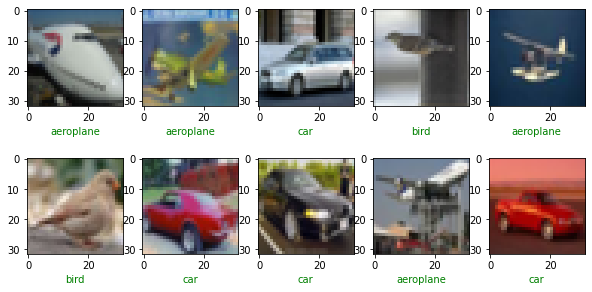

In [20]:
show_examples(x_train, y_train, y_train)

# Task 4: Create Model

In [21]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

In [22]:
def create_model():
  def add_conv_block(model, num_filters):
    model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(num_filters, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.5))
    return model
  model =tf.keras.models.Sequential()
  model.add(Input(shape=(32,32,3)))
  model = add_conv_block(model, 32)
  model = add_conv_block(model, 64)
  model = add_conv_block(model, 128)
  model.add(Flatten())
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
  return model

  

In [23]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 15, 15, 64)        1

# Task 5: Train the Model

In [24]:
history = model.fit(x_train/255., y_train, validation_data=(x_test/255., y_test), epochs=10, batch_size=128,
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3))

Epoch 1/10
118/118 [==============================] - 47s 365ms/step - loss: 0.8974 - accuracy: 0.6699 - val_loss: 2.3959 - val_accuracy: 0.3333
Epoch 2/10
118/118 [==============================] - 45s 383ms/step - loss: 0.5558 - accuracy: 0.7773 - val_loss: 2.7134 - val_accuracy: 0.4637
Epoch 3/10
118/118 [==============================] - 48s 408ms/step - loss: 0.4895 - accuracy: 0.8055 - val_loss: 2.0823 - val_accuracy: 0.5080
Epoch 4/10
118/118 [==============================] - 47s 396ms/step - loss: 0.4562 - accuracy: 0.8181 - val_loss: 1.7334 - val_accuracy: 0.5523
Epoch 5/10
118/118 [==============================] - 51s 436ms/step - loss: 0.4101 - accuracy: 0.8359 - val_loss: 0.7777 - val_accuracy: 0.7220
Epoch 6/10
118/118 [==============================] - 53s 451ms/step - loss: 0.3849 - accuracy: 0.8507 - val_loss: 0.7710 - val_accuracy: 0.7350
Epoch 7/10
118/118 [==============================] - 53s 452ms/step - loss: 0.3515 - accuracy: 0.8614 - val_loss: 0.7233 - val_ac

In [33]:
import pickle
# pickle_out = open('image_model.pkl', 'wb')
# pickle.dump(model, pickle_out)

# loaded_model = pickle.load(open('image_class_model.pkl', 'rb'))

# filename = 'image_class_model.pkl'
# with open(filename, 'rb') as f:
#     class_dict = pickle.load(f)

from joblib import dump, load
dump(model, 'image_class.joblib')
clf = load('image_class.joblib')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\conv2d_4
......vars
.........0
.........1
...layers\conv2d_5
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...layers\max_pooling2d_2
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......v

94/94 [==============================] - 3s 26ms/step


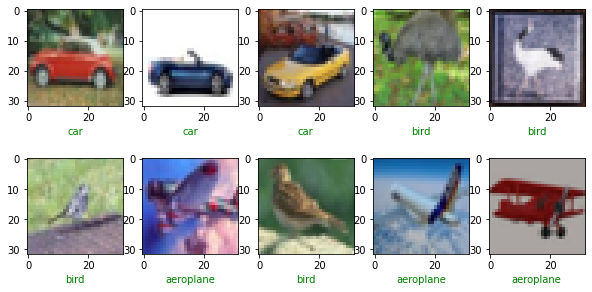

In [34]:
test_pred = clf.predict(x_test/255)
show_examples(x_test, y_test, test_pred)

# Task 6: Final Predictions

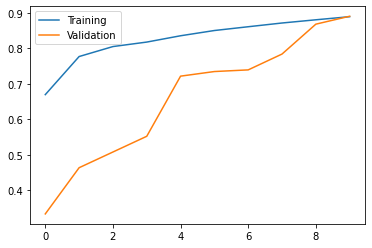

In [25]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(range(len(acc)), acc, label="Training")
plt.plot(range(len(acc)), val_acc, label="Validation")
plt.legend()
plt.show()


In [42]:
# pred = model.predict(x_test/255.)
# show_examples(x_test, y_test, pred)
# print(pred[0])

new_x_test = x_test/255.
# print(new_x_test)

print(new_x_test.shape)

(3000, 32, 32, 3)
